 Introduction

This dataset comes from a food delivery / taxi scenario, where each row represents a delivery or trip with pickup (restaurant) and drop-off (delivery) coordinates.

Objective: Find natural hotspots (zones of high demand) without predefining the number of clusters.

I chose  DBSCAN Unlike K-Means, DBSCAN can detect

Non-spherical clusters (odd-shaped delivery zones).

Outliers (deliveries far away from the main city).

Clusters automatically (no need to guess K).The benfits are the reason for chosing this algorithm

In [1]:
from google.colab import files
uploaded=files.upload()

Saving train.csv to train.csv


In [2]:
import pandas as pd

df=pd.read_csv("train.csv")

In [3]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [4]:
coordinates= df[['Delivery_location_latitude','Delivery_location_longitude']].dropna()     #.values not using this as it will become numpy array
                                                                                            #Let it stayu a data frame and dropping missing values that are of no use


In [5]:
print("Shape of coords:", coordinates.shape)

Shape of coords: (45593, 2)


In [18]:
coordinates.head()

,Delivery_location_latitude,Delivery_location_longitude
0,22.765049,75.912471
1,13.043041,77.813237
2,12.924264,77.688400
3,11.053669,77.026494
4,13.012793,80.289982


In [19]:
from sklearn.preprocessing import StandardScaler

coords_scaled = StandardScaler().fit_transform(coordinates)
print("Scaled coords shape:", coords_scaled.shape)     # scaling becomes important as Dbscan is using Euclidean distance L2

Scaled coords shape: (45593, 2)


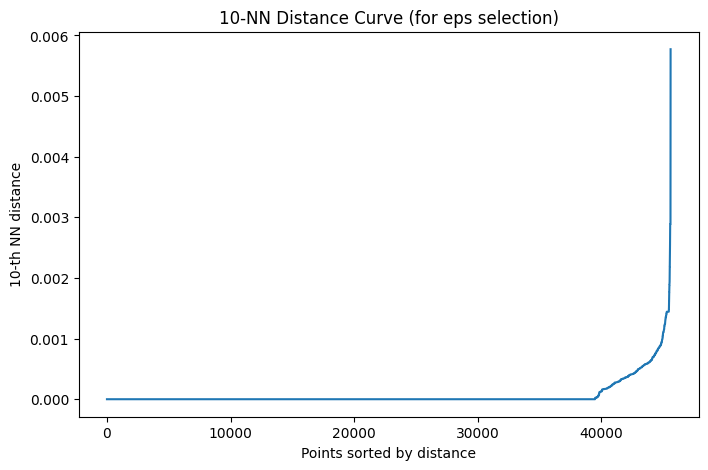

In [20]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

MIN_SAMPLES = 10  # I can tweak it but lets keep it 10 think as the number of taxis or drivers
                  #needs to be staffed to make the cluster operational and justified

neighbors = NearestNeighbors(n_neighbors=MIN_SAMPLES,algorithm="auto")   #initializing nearest neighbours that starts with a random point of cordinate set
                                                                         #how its searching like kd tree brute or ball-tree
neighbors_fit = neighbors.fit(coords_scaled)  #fiting on cordinates that are scaled
distances_all, indices_all = neighbors_fit.kneighbors(coords_scaled)   # Array of Distcances to the 10th nearest neigbour for each point and its index number(row)

# for each pt selecting the distance to its 10th nearest neighbour (indexed at 9)to choose optimal eps and then sorting it ascending order
distances = np.sort(distances_all[:, MIN_SAMPLES-1])


#plotting NN distance curve
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title(f"{MIN_SAMPLES}-NN Distance Curve (for eps selection)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{MIN_SAMPLES}-th NN distance")
plt.show()



EPS Selection Insight

After plotting the 10-NN distance curve for eps selection, we can observe the following

- The curve stays almost flat in the beginning → this indicates **dense regions** where points are very close together.  
- Around **0.002**, the curve starts bending upward → this is the **elbow point** where we begin to capture **medium-dense regions** as well.  
- Beyond this, the curve shoots up steeply → those are **far-flung / outlier points**, and including them would make eps too large, merging clusters that shouldn’t be merged.  

 Therefore, an optimal choice of **eps ≈ 0.002** balances the trade-off:  
- Captures both **dense and moderately dense clusters**  
- Ignores **redundant outliers** that don’t contribute to meaningful clusters  


In [22]:
# seeing the distance of the target and 10th nearest neighbour for all point(outer boundary of 10nn circle)
distances = np.sort(distances_all[:, MIN_SAMPLES-1])
print(distances)

[0.         0.         0.         ... 0.00577284 0.00577284 0.00577284]


In [23]:
distances.shape

(45593,)

In [19]:
from sklearn.cluster import DBSCAN
import numpy as np

eps_values = [0.0015, 0.002, 0.0025, 0.003]
MIN_SAMPLES = 10

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=MIN_SAMPLES, metric='euclidean')
    labels = db.fit_predict(coords_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_pct = n_noise / len(labels) * 100

    print(f"eps={eps:.4f} → clusters={n_clusters}, noise points={n_noise} ({noise_pct:.2f}%)")


    #DBSCAN gives me a labels array where each cluster is numbered like 0,1,2… and anything that doesn’t belong to a cluster is marked as -1 outlier.

    # Now, I don’t want to treat -1 as a cluster, so I’m doing:

# n_clusters = len(set(labels)) - (1 if -1 in labels else 0) → basically count all the unique clusters, but if -1 is there, just subtract it because noise ≠ cluster.

# n_noise = list(labels).count(-1) → here I’m just counting how many points actually got tagged as noise.

# So at the end, I know two things:
#  how many proper clusters DBSCAN actually found
#  how many points were left out as outliers which is -1

eps=0.0015 → clusters=92, noise points=81 (0.18%)
eps=0.0020 → clusters=64, noise points=30 (0.07%)
eps=0.0025 → clusters=56, noise points=20 (0.04%)
eps=0.0030 → clusters=28, noise points=0 (0.00%)


In [25]:
# going with best eps  eps=0.0020 → clusters=64, noise points=30 (0.07%)

from sklearn.cluster import DBSCAN

EPS = 0.002   # chosen eps from k-distance plot
MIN_SAMPLES = 10

db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='euclidean')
labels = db.fit_predict(coords_scaled)

# Adding  labels to my  dataframe
coordinates['cluster'] = labels

# Summary of the chosen eps
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Final DBSCAN run → clusters={n_clusters}, noise points={n_noise}")

Final DBSCAN run → clusters=64, noise points=30


In [26]:
cluster_summary = (
    coordinates[coordinates['cluster'] != -1]
    .groupby('cluster')
    .agg(
        size=('Delivery_location_latitude', 'size'),
        center_lat=('Delivery_location_latitude', 'mean'),
        center_lon=('Delivery_location_longitude', 'mean')
    )
    .sort_values('size', ascending=False)
    .reset_index()
)

print("Susnata's Top 10 Taxi hotspots recomendations(cluster_id, size, center_lat, center_lon):")
print(cluster_summary.head(10))

Susnata's Top 10 Taxi hotspots recomendations(cluster_id, size, center_lat, center_lon):
   cluster  size  center_lat  center_lon
0       15  3237   26.970862   75.861016
1       16  3187   21.232149   72.851053
2        2  3170   11.072403   77.040819
3        4  3138   17.497860   78.469290
4        3  3102   13.095918   80.300294
5        6  3012   12.381562   76.694162
6        0  2995   22.803943   75.951275
7        1  2987   13.013020   77.698952
8       20  2971    0.050141    0.050141
9       12  2964   19.185291   72.909500



size = number of points in the cluster (e.g 3,327 drop-off,rider  or taxis).

center_lat/lon = cluster centroid (delivery hotspot).

Think of size as the demand volume, and the center as the ideal place to station riders or taxis

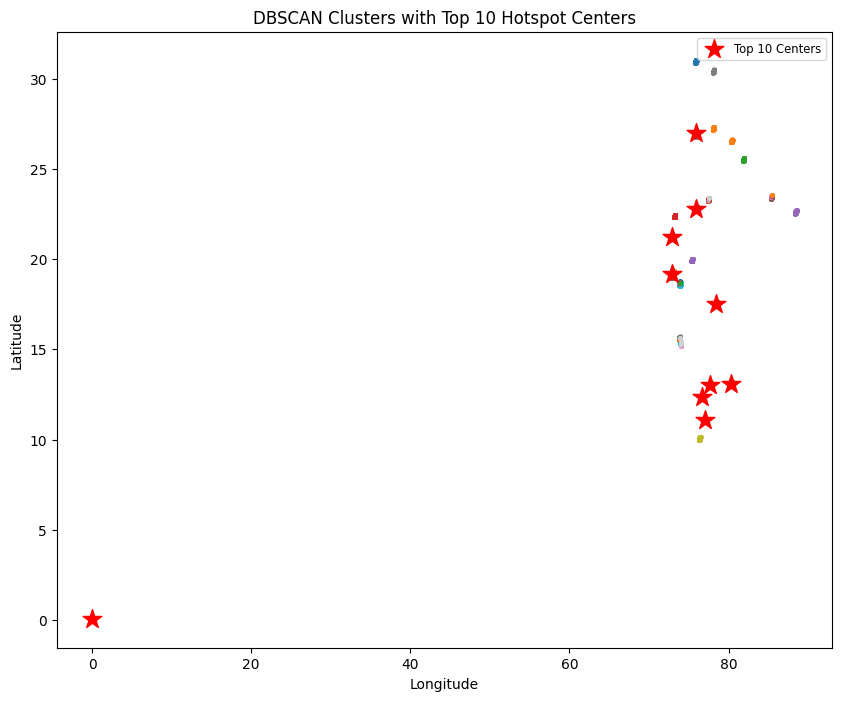

In [27]:
#Visualizing through scatter plot

plt.figure(figsize=(10,8))

unique_labels = set(coordinates['cluster'])

for lab in unique_labels:
    subset = coordinates[coordinates['cluster'] == lab]
    if lab == -1:
        plt.scatter(subset['Delivery_location_longitude'],
                    subset['Delivery_location_latitude'],
                    c='lightgray', s=5, alpha=0.5)
    else:
        plt.scatter(subset['Delivery_location_longitude'],
                    subset['Delivery_location_latitude'],
                    s=5, alpha=0.6)

# Top 10 centers
plt.scatter(cluster_summary['center_lon'].head(10),
            cluster_summary['center_lat'].head(10),
            c='red', s=200, marker='*', label='Top 10 Centers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clusters with Top 10 Hotspot Centers")
plt.legend(fontsize="small")   # shows only the red stars or top 10 centers
plt.show()

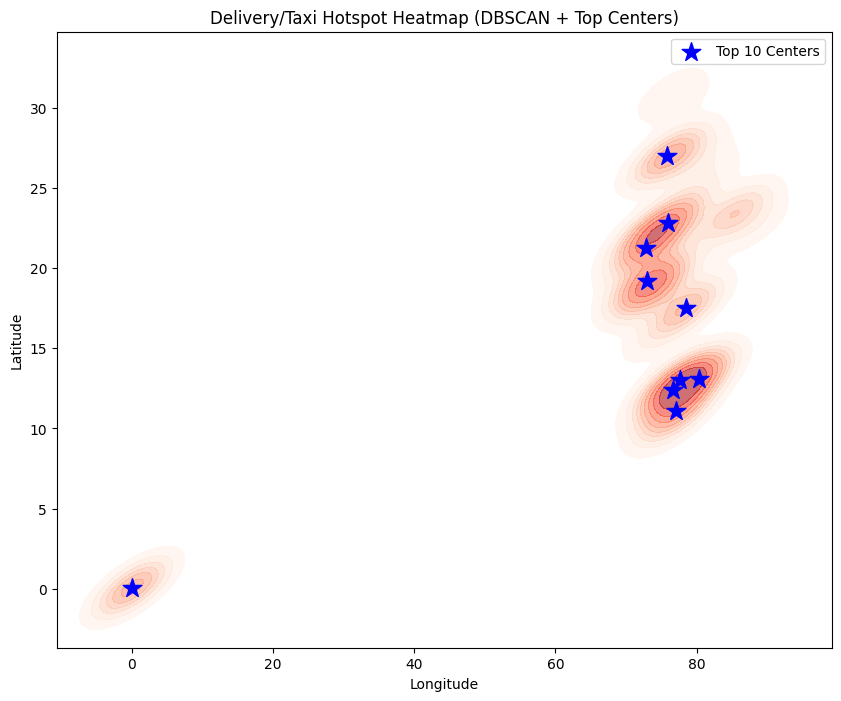

In [28]:
# Also doing a visual heatmap to see densities red are dense clusters,lighter areas are sparser

#I also overlaid the top 10 clusters blue starts  to see how well the align with hotsposts

import seaborn as sns

plt.figure(figsize=(10,8))
sns.kdeplot(
    x=coordinates['Delivery_location_longitude'],
    y=coordinates['Delivery_location_latitude'],
    fill=True, cmap="Reds", thresh=0.05, alpha=0.6
)
plt.scatter(cluster_summary['center_lon'].head(10),
            cluster_summary['center_lat'].head(10),
            c='blue', s=200, marker='*', label='Top 10 Centers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Delivery/Taxi Hotspot Heatmap (DBSCAN + Top Centers)")
plt.legend()
plt.show()

Susnata's Conclusion

DBSCAN gave us

Natural delivery/taxi hotspots.

No need to predefine clusters.

Ability to filter noise/outliers.

Operationally:

Helps allocate riders to zones (min_samples ≈ number of riders needed).

Helps identify top 10 busiest areas for resource prioritization.

Provides a heatmap for visual demand distribution.